MP1

In [336]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.patches as patches

#Keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

In [337]:
seed = 5
np.random.seed(seed)

In [338]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]



def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

Simple Classification

In [339]:
#Generation of data
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


Gradient descent optimizer

In [499]:
#Sortie: 0=rectangle, 1=disk, 2=rectangle
nb_neurons = 32
modelsgd = Sequential([
    Dense(nb_neurons, input_shape=(5184,)),
    Activation('relu'),
    Dense(3),
    Activation('softmax')])
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
modelsgd.compile(loss = 'mean_squared_error' , optimizer=sgd, metrics=['accuracy'])
labels = np_utils.to_categorical(Y_train, num_classes=3)
modelsgd.fit(X_train, labels, epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 1s 5ms/step - loss: 0.3278 - acc: 0.3900
Epoch 2/10
300/300 [==============================] - 0s 230us/step - loss: 0.1838 - acc: 0.5733
Epoch 3/10
300/300 [==============================] - 0s 230us/step - loss: 0.1541 - acc: 0.6667
Epoch 4/10
300/300 [==============================] - 0s 245us/step - loss: 0.1146 - acc: 0.8000
Epoch 5/10
300/300 [==============================] - 0s 193us/step - loss: 0.0873 - acc: 0.8333
Epoch 6/10
300/300 [==============================] - 0s 230us/step - loss: 0.0714 - acc: 0.8633
Epoch 7/10
300/300 [==============================] - 0s 253us/step - loss: 0.0578 - acc: 0.9000
Epoch 8/10
300/300 [==============================] - 0s 237us/step - loss: 0.0599 - acc: 0.8600
Epoch 9/10
300/300 [==============================] - 0s 230us/step - loss: 0.0462 - acc: 0.9200
Epoch 10/10
300/300 [==============================] - 0s 208us/step - loss: 0.0463 - acc: 0.9067


Our algorithm will return a list with zeroes and one. The position of the "1" indicate if our image is a rectangle, a disk or a triangle.

In [500]:
#We test our model
X_rectangle = generate_a_rectangle()
X_disk = generate_a_disk()
X_triangle = generate_a_triangle()[0]
X_rectangle = X_rectangle.reshape(1, X_rectangle.shape[0])
X_disk = X_disk.reshape(1, X_disk.shape[0])
X_triangle = X_triangle.reshape(1, X_triangle.shape[0])
print(modelsgd.predict(X_rectangle))
print(modelsgd.predict(X_disk))
print(modelsgd.predict(X_triangle))

[[1. 0. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]


Adam optimizer

In [450]:
nb_neurons = 32
modeladam = Sequential([
    Dense(nb_neurons, input_shape=(5184,)),
    Activation('relu'),
    Dense(3),
    Activation('softmax')])
modeladam.compile(loss = 'categorical_crossentropy' , optimizer='adam', metrics=['accuracy'])
labels = np_utils.to_categorical(Y_train, num_classes=3)
modeladam.fit(X_train, labels, epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 0s 208us/step - loss: 0.4596 - acc: 0.7167
Epoch 2/10
300/300 [==============================] - 0s 230us/step - loss: 0.4471 - acc: 0.7433
Epoch 3/10
300/300 [==============================] - 0s 230us/step - loss: 0.4133 - acc: 0.7933
Epoch 4/10
300/300 [==============================] - 0s 208us/step - loss: 0.3825 - acc: 0.8233
Epoch 5/10
300/300 [==============================] - 0s 230us/step - loss: 0.3477 - acc: 0.9100
Epoch 6/10
300/300 [==============================] - 0s 178us/step - loss: 0.3253 - acc: 0.9267
Epoch 7/10
300/300 [==============================] - 0s 260us/step - loss: 0.2931 - acc: 0.9233
Epoch 8/10
300/300 [==============================] - 0s 189us/step - loss: 0.2835 - acc: 0.9500
Epoch 9/10
300/300 [==============================] - 0s 271us/step - loss: 0.2548 - acc: 0.9633
Epoch 10/10
300/300 [==============================] - 0s 230us/step - loss: 0.2379 - acc: 0.9433


In [451]:
#We test our model
X_rectangle = generate_a_rectangle()
X_disk = generate_a_disk()
X_triangle = generate_a_triangle()[0]
X_rectangle = X_rectangle.reshape(1, X_rectangle.shape[0])
X_disk = X_disk.reshape(1, X_disk.shape[0])
X_triangle = X_triangle.reshape(1, X_triangle.shape[0])
print(modeladam.predict(X_rectangle))
print(modeladam.predict(X_disk))
print(modeladam.predict(X_triangle))

[[1. 0. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]


Visualization of the Solution

In [426]:
modeladam.get_weights()

[array([[ 1.1502532e-02, -1.5444164e-02,  1.2425272e-02, ...,
          1.0970334e-02,  2.6869236e-03, -2.7857663e-02],
        [ 5.4817628e-03, -2.3383845e-02,  2.8143367e-02, ...,
          1.4144349e-02,  2.7237518e-02,  2.3628594e-02],
        [-7.9836678e-03, -3.2841541e-02,  4.4636223e-03, ...,
         -9.1962582e-03,  1.6791269e-02, -2.0557925e-02],
        ...,
        [-8.8043511e-05,  1.5177386e-02, -2.1784257e-02, ...,
         -2.5087407e-02,  1.3313531e-02, -2.4526177e-02],
        [-1.7986566e-02, -3.3816226e-02, -6.1920676e-03, ...,
          5.4822788e-03, -1.5481466e-03,  2.3005603e-02],
        [-6.9417227e-03,  1.3733514e-02, -1.4288149e-02, ...,
         -1.6891539e-02, -1.1691088e-02,  2.0780852e-02]], dtype=float32),
 array([ 0.        , -0.00589088,  0.        , ..., -0.00581686,
         0.00662128,  0.        ], dtype=float32),
 array([[ 0.01369356, -0.00964056,  0.03092562],
        [ 0.02601969,  0.01925899,  0.00698442],
        [-0.02017078, -0.03684411,  

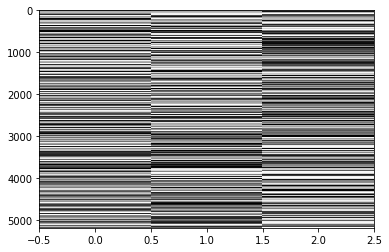

In [535]:
plt.imshow(model.get_weights()[0][:,0:3], aspect='auto', cmap='gray')

A More Difficult Classification Problem

In [545]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [550]:
nb_neurons = 32
model = Sequential([
    Dense(nb_neurons, input_shape=(5184,)),
    Activation('relu'),
    Dense(3),
    Activation('softmax')])
model.compile(loss = 'categorical_crossentropy' , optimizer='adam', metrics=['accuracy'])
labels = np_utils.to_categorical(Y_train, num_classes=3)
model.fit(X_train, labels, epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 2s 5ms/step - loss: 2.0572 - acc: 0.3133
Epoch 2/10
300/300 [==============================] - 0s 230us/step - loss: 1.2712 - acc: 0.3667
Epoch 3/10
300/300 [==============================] - 0s 208us/step - loss: 1.0328 - acc: 0.4800
Epoch 4/10
300/300 [==============================] - 0s 230us/step - loss: 0.9727 - acc: 0.4900
Epoch 5/10
300/300 [==============================] - 0s 230us/step - loss: 1.1275 - acc: 0.4500
Epoch 6/10
300/300 [==============================] - 0s 208us/step - loss: 0.9710 - acc: 0.5033
Epoch 7/10
300/300 [==============================] - 0s 230us/step - loss: 0.9491 - acc: 0.5533
Epoch 8/10
300/300 [==============================] - 0s 230us/step - loss: 1.0192 - acc: 0.5233
Epoch 9/10
300/300 [==============================] - 0s 230us/step - loss: 0.8440 - acc: 0.6133
Epoch 10/10
300/300 [==============================] - 0s 208us/step - loss: 0.8078 - acc: 0.6533


In [551]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [552]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 1s 2ms/step


[0.9467106572786967, 0.5533333325386047]

A Regression Problem

Image Denoising